# Regresion Lineal con PyTorch

### Entrena y evalua un modelo de regresion lineal para el conjunto de datos de calificaciones que considere los dos atributos de entrada

In [1]:
#importamos librerias utiles
#Deep Learning
import torch
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets.utils import download_url
#matrices, tablas y matematicas
import numpy as np
import pandas as pd
#graficacion
from matplotlib import pyplot as plt
#acceso a carpetas del sistema
import os
#para hacer graficas en 3D
from mpl_toolkits.mplot3d import Axes3D
#para tomar elementos de una secuencia
from itertools import islice as take
import time

In [2]:
#sembramos semilla aleatoria para reproducibilidad
torch.manual_seed(2020)
#descargamos
download_url('https://raw.githubusercontent.com/gibranfp/CursoAprendizajeProfundo/master/data/califs/califs.csv','data')

Using downloaded and verified file: data\califs.csv


In [3]:
#cargamos los datos
calificaciones = pd.read_csv('data/califs.csv', names = ['Calificacion Anterior', 'Horas de estudio', 'Calificacion'])
#mostamos la cebecera, los primeros diez elementos
calificaciones.head(10)

,Calificacion Anterior,Horas de estudio,Calificacion
0,5.638,8.289,5.136
1,6.744,9.389,5.931
2,5.136,10.060,5.484
3,5.748,10.421,6.524
4,7.136,10.434,6.770
5,6.489,10.437,6.039
6,6.148,10.460,6.871
7,6.834,10.518,6.272
8,6.381,10.768,7.236
9,6.274,10.948,7.279


###  Grafica los datos en 3D

In [4]:
#funcionpara observar un grafico 3D de puntos (x,y,z)
#x,y,z son las posiciones de los puntos a observar
def grafico3D(x,y,z):  
    #para hacer un grafico interactivo
    #%matplotlib notebook
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1,1,1, projection='3d')
    #definimos los nombres de los ejes
    ax.set_ylabel('Horas de estudio')
    ax.set_xlabel('Calificacion Anterior')
    ax.set_zlabel('Calificacion')
    ax.set_title('Calificacion en funcion de la calif anterior y las horas de estudio \n puntos rojos representan alumnos con calificacion menor a 6.0')
    for i in range(x.shape[0]):
        if z[i] >= 6.0:
            plt.plot(x[i], y[i], z[i], 'o', color='gold')
        else:
            plt.plot(x[i], y[i], z[i], 'o', color='red')
    #plt.close(fig)

In [5]:
#Definimos las x,y,z a graficar
x = calificaciones['Calificacion Anterior'][:].to_numpy()
y = calificaciones['Horas de estudio'][:].to_numpy()
z = calificaciones['Calificacion'][:].to_numpy()

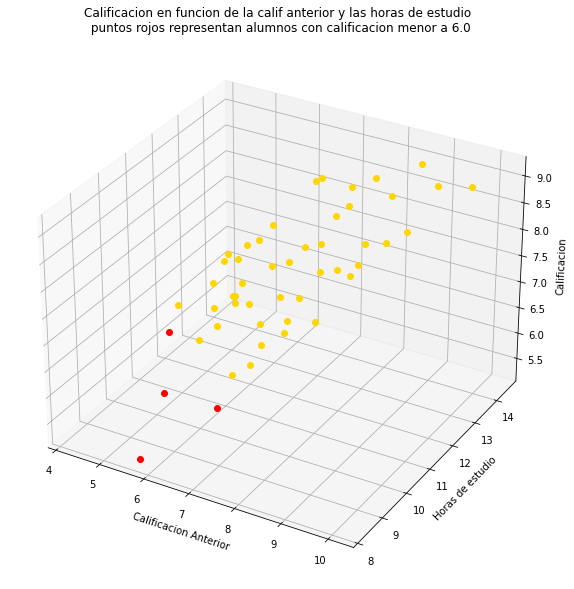

In [6]:
grafico3D(x,y,z)
#plt.close()

### Realiza la definicion de la arquitectura usando la interfaz de alto como la de medio nivel

In [7]:
## Definimos nuestra clase data set:
class DataSetCalif:
    #creamos la funcion que inicializa el dataset
    def __init__(self, x, y):
        self.x = x
        self.y = y
    #creamos la funcion que nos regresa un solo ejemplo
    def __getitem__(self, i):
        return self.x[i], self.y[i]
    #creamos la funcion que nos dice la cantidad de elementos en el dataset
    def __len__(self):
        return len(self.x)

In [8]:
#antes de instanciar el data set es necesario pasar x,y,z a vectores columna, por defecto numpy los lee con un shape
#tipo (w,) y nosotros queremos (w,1) para esto usamos np.newaxis
#dado que vamos a usar x, y como variables independientes hay que pegarlas
x = x[:,np.newaxis]
y = y[:,np.newaxis]
z = z[:,np.newaxis]
X = np.concatenate((x,y),axis=1)
#pytorch pide que nuestros vectores sean del tipo float 32
x = np.float32(x)
y = np.float32(y)
z = np.float32(z)
X = np.float32(X)
#imprimimos el shape de nuestros vectores
print('El shape de x es {0}, el sahpe de y es {1}, el shape de z es {2}'.format(x.shape, y.shape, z.shape))
#imprimimos el tipo de x, y, z
print('El tipo de x es {0}, el tipo de y es {1}, el tipo de z es {2}'.format(x.dtype, y.dtype, z.dtype))
print('El shape de X es {0}, el tipo de X es {1}'.format(X.shape, X.dtype))

El shape de x es (50, 1), el sahpe de y es (50, 1), el shape de z es (50, 1)
El tipo de x es float32, el tipo de y es float32, el tipo de z es float32
El shape de X es (50, 2), el tipo de X es float32


In [9]:
#instanciamos el data set con nuestros datos
ds = DataSetCalif(X,z)
# instanciamos el cargador de datos de torch
trainDataL = DataLoader(ds, batch_size=16, shuffle = True)
#tomamos un elemento de los datos cargados y los mostramos esto para asegurar que si se cargaron bien
for w, zz in take(trainDataL, 1):
    print(f'x shape={w.shape} dtype={w.dtype}')
    print(f'z shape={zz.shape} dtype={zz.dtype}')

x shape=torch.Size([16, 2]) dtype=torch.float32
z shape=torch.Size([16, 1]) dtype=torch.float32


In [10]:
#imprimimos la longitud del dataset
print('El tamaño total del data set es {}'.format(ds.__len__()))

El tamaño total del data set es 50


Dado que estamos haciendo clasificacion lineal y en la misma buscamos una funcion tal que $$f(x) = W^{T}\vec{x} + \vec{b}$$ sea la que presente el minimo error para los datos de entrada. Entonces nuestra arquitectura consiste unicamente de una neurona con funcion de activacion lineal.

#### Alto nivel

In [11]:
regLinear = nn.Sequential(
    nn.Linear(2, 1, True)
)

La documentacion nos dice que torch.nn.Linear(in_features: int, out_features: int, bias: bool = True), donde:

* in_features – size of each input sample
* out_features – size of each output sample
* bias – If set to False, the layer will not learn an additive bias. Default: True

2 es el tamaño de los datos (x,y), 1 es el tamaño de la salida (z), queremos un bias asi que ponemos True en el argumento

#### Medio nivel

In [12]:
class RegLinearMid(nn.Module):
    #definimos la funcion instanciadora
    def __init__(self):
        # se llama al instanciador de la clase padre implementado en torch
        super(RegLinearMid, self).__init__()
        #definimos las capas, estas deben ser atributos de la clase
        self.fc = nn.Linear(2, 1, True)
    #definimos la funcion de propagacion que usa el atributo de la clase
    #el nombre de la funcion forward no debe cambiarse, si se hace el codigo no jala esto por la clase padre
    def forward(self, x):
        return self.fc(x)

In [13]:
#instanciamos a partir de la clase RegLinearMid
regLinearMid = RegLinearMid()

In [14]:
#imprimimos ambos modelos
print('Alto nivel --> {0}'.format(regLinear))
print('Medio nivel --> {0}'.format(regLinearMid))

Alto nivel --> Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
)
Medio nivel --> RegLinearMid(
  (fc): Linear(in_features=2, out_features=1, bias=True)
)


#### Probando ambas arquitecturas con un dato sintetico (buenas practicas)

In [15]:
#definimos un dato sintetico de puros ceros (tensor de dimension 1,2) con ceros
prueba = torch.zeros(8,2)
#predecimos con nuestros modelos el dato sintetico
prediccionAlto = regLinear(prueba)
prediccionMedio = regLinearMid(prueba)
print('El tipo del vector sintetico es {0}. El shape y tipo de la prediccion de alto nivel es {1}, {2}.'
      'El shape y tipo de la prediccion de medio nivel es {3}, {4}.'.format(prueba.dtype, prediccionAlto.shape,
                                                                            prediccionAlto.dtype, prediccionMedio.shape,
                                                                            prediccionMedio.dtype))

El tipo del vector sintetico es torch.float32. El shape y tipo de la prediccion de alto nivel es torch.Size([8, 1]), torch.float32.El shape y tipo de la prediccion de medio nivel es torch.Size([8, 1]), torch.float32.


### Ciclo de entrenamiento

In [16]:
def entrename(X, modelo, epochs, learningRate):
    #sembramos semilla aleatoria para reproducibilidad
    torch.manual_seed(2020)
    #funcion para resetear los pesos, esta funcion es util para reproducibilidad de todos los modelos
    #dado que vamos a usar el mismo modelo pero con diferentes hiperparametros es necesario resetear los pesos
    def weight_reset(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            m.reset_parameters()
    #se resetean los pesos con la funcion anterior
    modelo.apply(weight_reset)
    #definimos el optimizador o el algoritmo a emplear para el entrenamiento.
    #Para nuestro caso usaremos descenso del gradiente estocastico SGD
    opt = optim.SGD(modelo.parameters(), lr=learningRate)
    #creamos una lista donde se guardaran las perdidas por cada epoco
    lossHistory = []
    #lossHistory = np.zeros()
    #iteramos sobre todas las epocas
    for epoch in range(epochs):
        #iteramos sobre todos los ejemplos del batch
        for a, b in X:
            #para debug
            #print(a)
            #hacemos la prediccion
            prediccion = modelo(a)
            #calculamos la perdida usando la funcion mean squared error
            loss = func.mse_loss(prediccion, b)
            #vaciamos los gradientes para que los calculos anteriores no interfieran con los nuevos
            opt.zero_grad()
            #hacemos la retropropagacion del error
            loss.backward()
            # actualizamos los parametros por descenso del gradiente
            opt.step()
            #almacemamos la perdida actual en el historial de perdidas
            lossHistory.append(loss.item())
    #regresamos los parametros calculados (matriz de peso y el sesgo), asi como el historial de perdidas
    return modelo.parameters(), lossHistory

In [17]:
def graficaError(historicoPerdidas):
    plt.plot(np.arange(len(historicoPerdidas)), historicoPerdidas, 'o', label='Perdida', color = 'blue')
    plt.xlabel('iteraciones')
    plt.ylabel('Eror Cuadratico Medio')
    plt.grid(True)
    plt.show()

In [18]:
def graficaPuntosyPrediccion(x,y,z,X,model):
    x_tr = torch.from_numpy(X)
    #y_tr = torch.from_numpy(y_train)
    with torch.no_grad():
        z_pred = model(x_tr).numpy()
    
    fig = plt.gcf()
    fig.set_size_inches(8, 8)
    ax = plt.axes(projection='3d')
    ax.scatter(x, y, z, color='blue', s=100)
    ax.scatter(x, y, z_pred, color='red', s=100)
    plt.show()

In [19]:
def imprimeParam(w,b):
    print('Los parametros aprendidos de W son {0}'.format(w.detach().numpy()))
    print('Los parametros aprendidos de b son {0}'.format(b.detach().numpy()))

In [20]:
def predice(horasEstudio,califAnterior,modelo):
    prediccion = torch.tensor([[horasEstudio, califAnterior]])
    with torch.no_grad():
        y_pred = modelo(prediccion).numpy()
    print('El alumno obtendra {0} de calificacion en el siguiente examen'.format(y_pred[0][0]))

### Graficando El error cuadratico medio, Los puntos originales y su prediccion y prediciendo para un valor especifico.

Se van a variar los parametros, analizaremos uno a uno y se dira que parametros se usaron

#### Modelo de Alto nivel con 3 epocas, learning rate de 0.001

In [21]:
## modelo de Alto nivel con 3 epocas, learning rate de 0.001
## Entrenamos
[wAlto,bAlto] , lossHistoryAlto = entrename(trainDataL, modelo=regLinear, epochs=3, learningRate = 0.001)

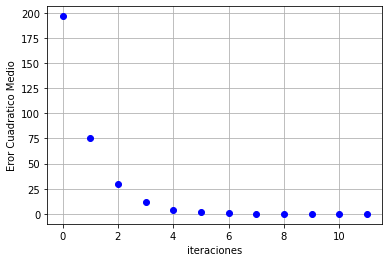

In [22]:
## modelo de Alto nivel con 3 epocas, learning rate de 0.001
#graficamos el error
graficaError(lossHistoryAlto)

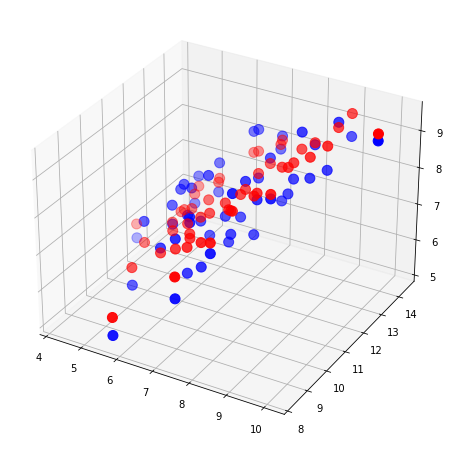

In [23]:
## modelo de Alto nivel con 3 epocas, learning rate de 0.001
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinear)

In [24]:
## modelo de Alto nivel con 3 epocas, learning rate de 0.001
##imprimimos parametros
imprimeParam(wAlto,bAlto)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinear)

Los parametros aprendidos de W son [[0.48119894 0.32867888]]
Los parametros aprendidos de b son [0.19794472]
El alumno obtendra 6.95836877822876 de calificacion en el siguiente examen


Para la configuracion de 3 epocas y un learning rate de 1e-3 vemos el ECM es muy proximo a cero. Asi mismo los puntos rojos y azules son similares pero no exactamente iguales. De esta forma podemos mejorar nuestros resultados al cambiar el learning rate, si aumentamos las epocas podriamos hacer overfit.

#### Modelo de Medio nivel con 3 epocas, learning rate de 0.001

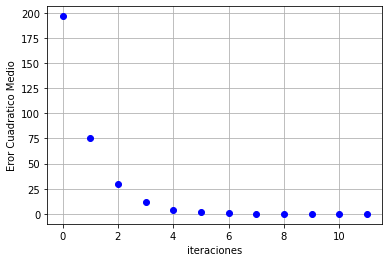

In [25]:
## modelo de Alto nivel con 3 epocas, learning rate de 0.001
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=3, learningRate = 0.001)
## modelo de medio nivel con 3 epocas, learning rate de 0.001
#graficamos el error
graficaError(lossHistoryMed)

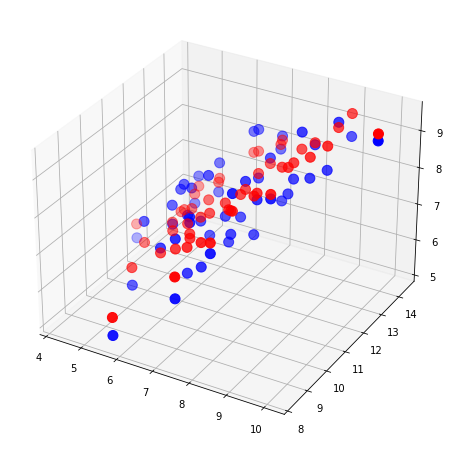

In [26]:
## modelo de medio nivel con 3 epocas, learning rate de 0.001
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [27]:
## modelo de Medio nivel con 3 epocas, learning rate de 0.001
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[0.48119894 0.32867888]]
Los parametros aprendidos de b son [0.19794472]
El alumno obtendra 6.95836877822876 de calificacion en el siguiente examen


Obtenemos los mismos resultados comparados con el modelo de alto nivel. Esto nos dice que hay consistencia entre ambos modelos

#### Modelo de Alto nivel con 3 epocas, learning rate de 0.01

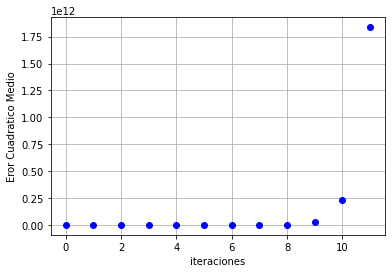

In [28]:
## modelo de Alto nivel con 3 epocas, learning rate de 0.01
## Entrenamos
[wAlto,bAlto] , lossHistoryAlto = entrename(trainDataL, modelo=regLinear, epochs=3, learningRate = 0.01)
## modelo de Alto nivel con 3 epocas, learning rate de 0.01
#graficamos el error
graficaError(lossHistoryAlto)

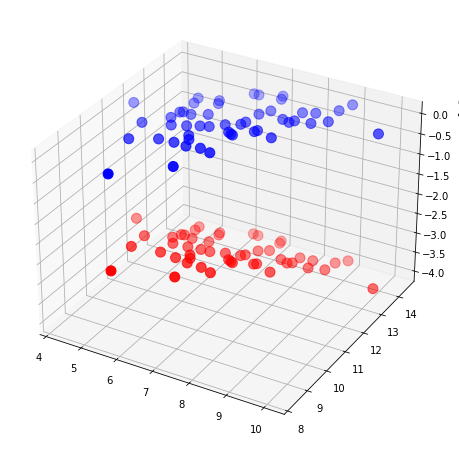

In [29]:
## modelo de Alto nivel con 3 epocas, learning rate de 0.01
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinear)

In [30]:
## modelo de Alto nivel con 3 epocas, learning rate de 0.01
##imprimimos parametros
imprimeParam(wAlto,bAlto)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinear)

Los parametros aprendidos de W son [[-106692.8  -208073.28]]
Los parametros aprendidos de b son [-20012.648]
El alumno obtendra -1924546.0 de calificacion en el siguiente examen


Para este caso observamos que con un learning rate de 0.01 y las mismas epocas obtenemos resultados bastante alejados de la realidad. De hecho el ecm se dispara. ¿Explosion del gradiente?

#### Modelo de Medio nivel con 3 epocas, learning rate de 0.01

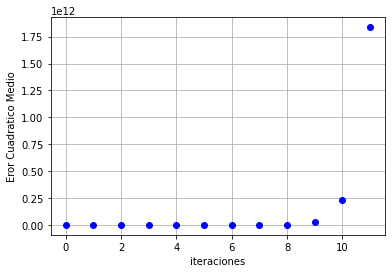

In [31]:
## modelo de Alto nivel con 3 epocas, learning rate de 0.01
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=3, learningRate = 0.01)
## modelo de medio nivel con 3 epocas, learning rate de 0.01
#graficamos el error
graficaError(lossHistoryMed)

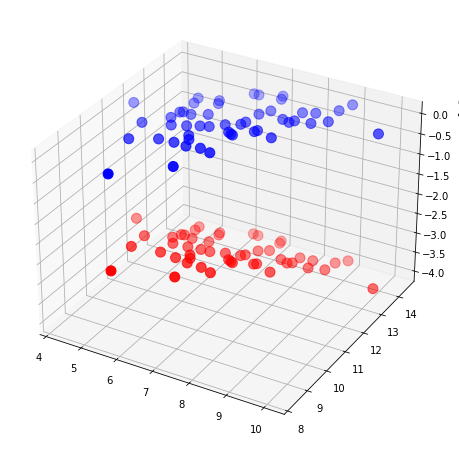

In [32]:
## modelo de medio nivel con 3 epocas, learning rate de 0.01
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [33]:
## modelo de Medio nivel con 3 epocas, learning rate de 0.01
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[-106692.8  -208073.28]]
Los parametros aprendidos de b son [-20012.648]
El alumno obtendra -1924546.0 de calificacion en el siguiente examen


Con el nivel medio sucede lo mismo que con el de alto nivel. Como ya vimos que los resultados son consistentes solo analizaremos el de nivel medio

#### Modelo de Medio nivel con 3 epocas, learning rate de 0.1

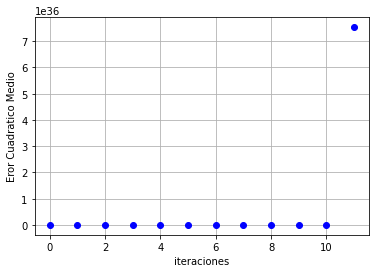

In [34]:
#### Modelo de Medio nivel con 3 epocas, learning rate de 0.1
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=3, learningRate = 0.1)
## modelo de medio nivel con 3 epocas, learning rate de 0.01
#graficamos el error
graficaError(lossHistoryMed)

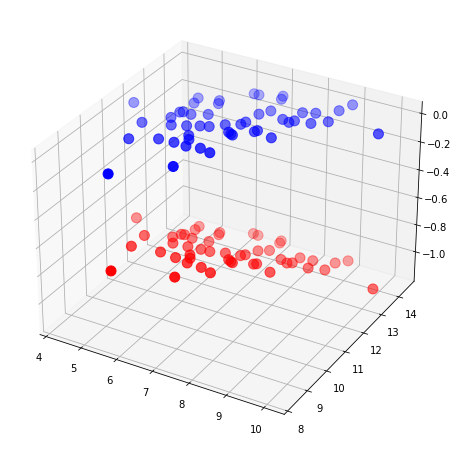

In [35]:
## modelo de medio nivel con 3 epocas, learning rate de 0.1
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [36]:
## modelo de Medio nivel con 3 epocas, learning rate de 0.01
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[-3.1620781e+18 -5.8932883e+18]]
Los parametros aprendidos de b son [-5.3421346e+17]
El alumno obtendra -5.615901654010089e+19 de calificacion en el siguiente examen


con un lr de 0.1 obtenemos resultados desfavorables

#### Modelo de Medio nivel con 3 epocas, learning rate de 1.0

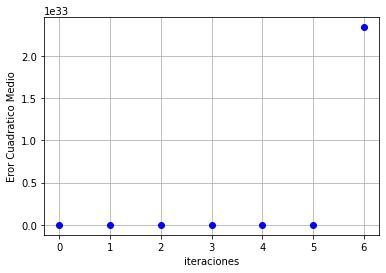

In [37]:
#### Modelo de Medio nivel con 3 epocas, learning rate de 1
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=3, learningRate = 1)
## modelo de medio nivel con 3 epocas, learning rate de 1
#graficamos el error
graficaError(lossHistoryMed)

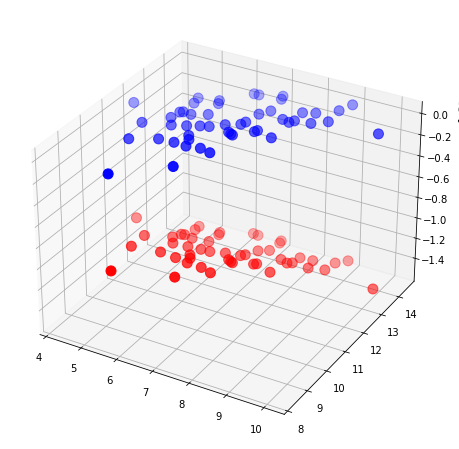

In [38]:
## modelo de medio nivel con 3 epocas, learning rate de 1
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [39]:
## modelo de Medio nivel con 3 epocas, learning rate de 1
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[-4.2287433e+30 -7.8624522e+30]]
Los parametros aprendidos de b son [-7.100792e+29]
El alumno obtendra -7.504235841361753e+31 de calificacion en el siguiente examen


Resultados desfavorables

#### Modelo de Medio nivel con 20 epocas, learning rate de 0.01

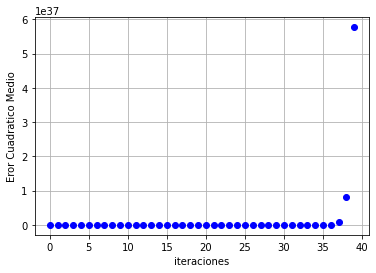

In [40]:
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=20, learningRate = 0.01)
## modelo de medio nivel con 3 epocas, learning rate de 1
#graficamos el error
graficaError(lossHistoryMed)

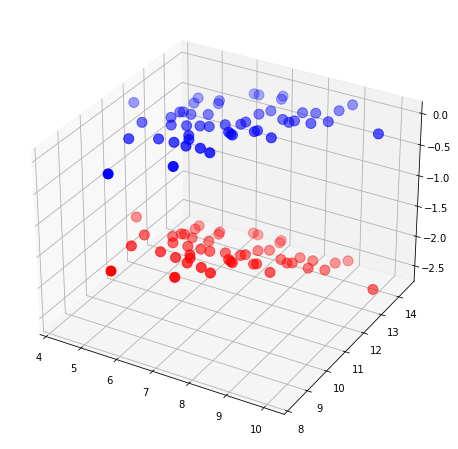

In [41]:
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [42]:
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[-7.6008465e+35 -1.3057370e+36]]
Los parametros aprendidos de b son [-1.0663624e+35]
El alumno obtendra -1.3144863601898018e+37 de calificacion en el siguiente examen


de aqui concluimos que el parametro mas importante es el learning rate y parece que debe ser menor a 0.001 para obtener resultados buenos

#### Modelo de Medio nivel con 3 epocas, learning rate de 0.0001

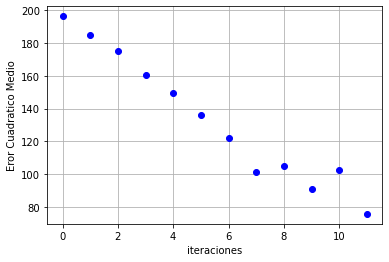

In [43]:
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=3, learningRate = 1e-4)
## modelo de medio nivel con 3 epocas, learning rate de 1
#graficamos el error
graficaError(lossHistoryMed)

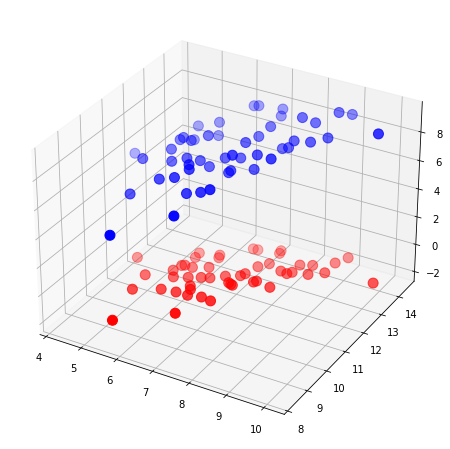

In [44]:
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [45]:
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[ 0.16592813 -0.22834344]]
Los parametros aprendidos de b son [0.15221097]
El alumno obtendra 1.4583181142807007 de calificacion en el siguiente examen


Para estos parametros observamos que el ecm si baja pero aun asi no es suficiente para considerar un buen ajuste pues los puntos rojos y azules se alejan demasiado

#### Modelo de Medio nivel con 10 epocas, learning rate de 0.0001

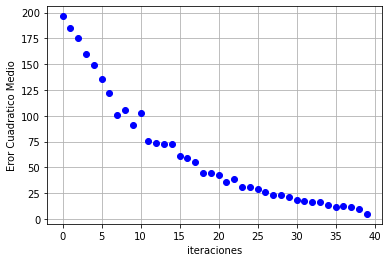

In [46]:
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=10, learningRate = 1e-4)
## modelo de medio nivel con 3 epocas, learning rate de 1
#graficamos el error
graficaError(lossHistoryMed)

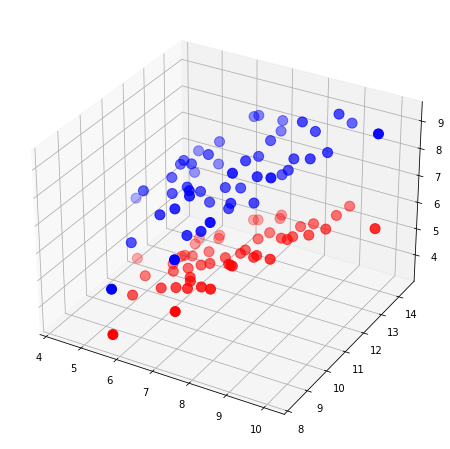

In [47]:
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [48]:
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[0.37432465 0.13852821]]
Los parametros aprendidos de b son [0.18249562]
El alumno obtendra 5.089975833892822 de calificacion en el siguiente examen


Los puntos siguen sin estar cercanos

#### Modelo de Medio nivel con 200 epocas, learning rate de 0.0001

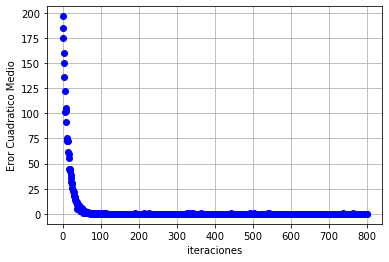

In [49]:
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=200, learningRate = 1e-4)
## modelo de medio nivel con 3 epocas, learning rate de 1
#graficamos el error
graficaError(lossHistoryMed)

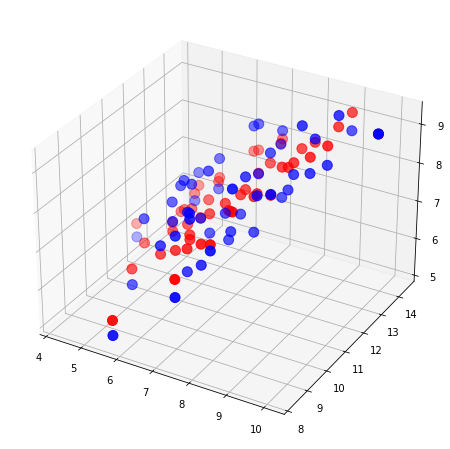

In [50]:
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [51]:
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[0.45170096 0.33660865]]
Los parametros aprendidos de b son [0.19778942]
El alumno obtendra 6.628026962280273 de calificacion en el siguiente examen


Para este caso tenemos que los puntos se acercan mejor comparado al caso de un lr de 0.001 y 3 epocas. Decimos que hasta ahora este es el mejor ajuste.
Tambien descubrimos que conviene poner un learning rate bajo y poner demasiadas epocas aunque esto hace que el tiempo de computo aumente

#### Modelo de Medio nivel con 2000 epocas, learning rate de 1e-6

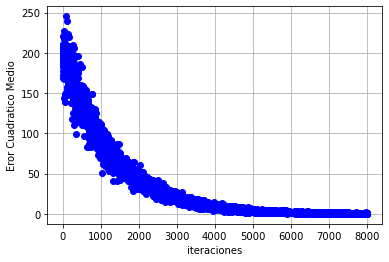

In [52]:
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=2000, learningRate = 1e-6)
## modelo de medio nivel con 3 epocas, learning rate de 1
#graficamos el error
graficaError(lossHistoryMed)

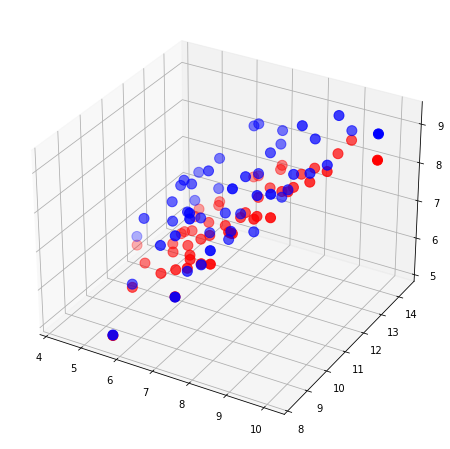

In [53]:
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [54]:
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[0.4555377 0.2846893]]
Los parametros aprendidos de b son [0.19402064]
El alumno obtendra 6.514541149139404 de calificacion en el siguiente examen


VEmos que obtenemos predicciones y graficas similares con respecto al lr de 1e-4 y 200 epocas y lr de 1e-0.3 y tres epocas donde la diferencia maxima de prediccion entre estos tres es de 0.3 puntos algo que consideramos aceptable.
Por otro lado vemos que la grafica de ecm para este caso es mas ruidosa comparada a las otras dos. Esto se debe a la cantidad de iteraciones realizadas y el valor pequeño del lr

#### Modelo de Medio nivel con 100 epocas, learning rate de 1e-3

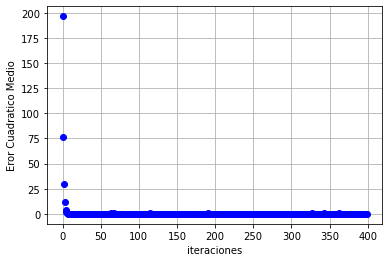

In [55]:
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=100, learningRate = 1e-3)
## modelo de medio nivel con 3 epocas, learning rate de 1
#graficamos el error
graficaError(lossHistoryMed)

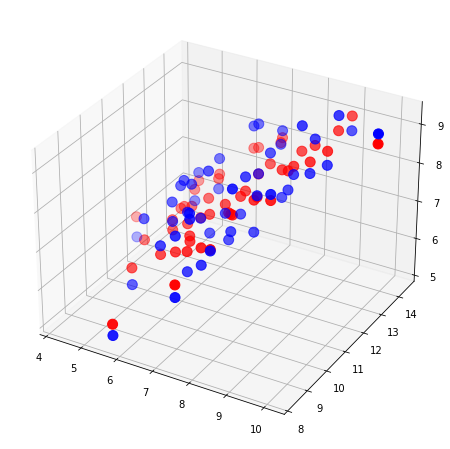

In [56]:
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [57]:
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[0.36545634 0.38338572]]
Los parametros aprendidos de b son [0.19780852]
El alumno obtendra 5.7334418296813965 de calificacion en el siguiente examen


Para esta configuracion observamos que la prediccion se aleja a las de las otras tres por aproximadamente 0.5 puntos. Debido a que el ecm converge a cero rapidamente decimos que con estos parametros estamos realizando un overfit por lo que la prediccion no es necesariamente correcta

#### Modelo de Medio nivel con 8 epocas, learning rate de 1e-3

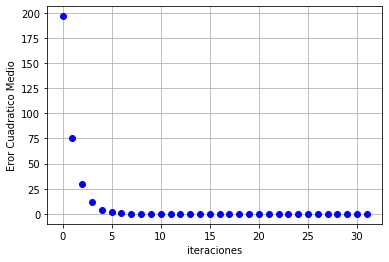

In [58]:
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=8, learningRate = 1e-3)
## modelo de medio nivel con 3 epocas, learning rate de 1
#graficamos el error
graficaError(lossHistoryMed)

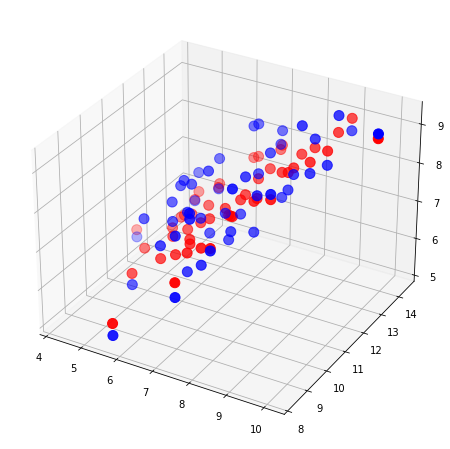

In [59]:
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [60]:
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[0.46570098 0.31765655]]
Los parametros aprendidos de b son [0.196839]
El alumno obtendra 6.73822021484375 de calificacion en el siguiente examen


con una menor cantidad de epocas vemos que las predicciones son mas consistentes con respecto a las otras tres y no observamos este fenomeno de convergencia inmediata. Asi mismo los puntos aparentan ser mas cercanos con respecto a la grafica anterior esto nos dice que efectivamente estabamos haciendo overfit con una gran cantidad de epocas

#### Modelo de Medio nivel con 25 epocas, learning rate de 0.0001

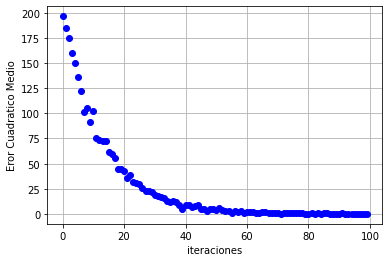

In [61]:
## Entrenamos
[wMed,bMed] , lossHistoryMed = entrename(trainDataL, modelo=regLinearMid, epochs=25, learningRate = 1e-4)
## modelo de medio nivel con 3 epocas, learning rate de 1
#graficamos el error
graficaError(lossHistoryMed)

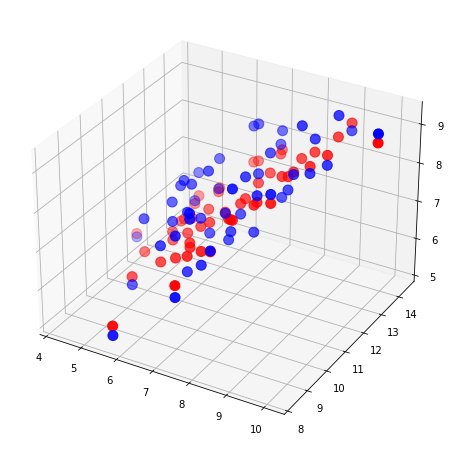

In [62]:
#graficamos los puntos reales (rojos) con su respectiva prediccion (azules)
#intuitivamente esperamos que los puntos rojos y azules esten mas cercanos entre si
graficaPuntosyPrediccion(x,y,z,X,regLinearMid)

In [63]:
##imprimimos parametros
imprimeParam(wMed,bMed)
#imprimimos prediccion para alguien que estudio 12 horas y saco 3 anteriormente
predice(horasEstudio=12.,califAnterior=3.,modelo=regLinearMid)

Los parametros aprendidos de W son [[0.46772557 0.3080811 ]]
Los parametros aprendidos de b son [0.19636172]
El alumno obtendra 6.733312129974365 de calificacion en el siguiente examen


Esta configuracion es tambien consistente con las demas

#### Conclusion

* Los parametros optimos de learning rate para este problema son 1e-3 y 1e-4, y el numero de epocas es de 8 y 25 respectivamente
* Debido a la poca cantidad de datos no es posible determinar que ajuste fue el optimo ya que no se cuenta con datos de validacion, pero podemos decir que el estudio de los hiperparametros y la observacion de las graficas nos dice que el alumno con los parametros de la prediccion aprobara el siguiente examen con una calificacion aproximada de 6.5
* La variacion de los hiperparametros nos muestra que podemos realizar overfitting si excedemos la cantidad de epocas
* El hecho de que el lr deba ser bajo y las epocas relativamente altas es un hecho trivial de explicar, el ecm es una funcion completamente convexa con un solo minimo, por lo que alcanzarlo unicamente dependera del lr que depende del gradiente, si el lr es muy pequeño necesitaremos una cantidad muy grande de epocas para alcanzarlo, en cambio si el lr es alto entonces es posible que nunca se alcance, es por esta ultima razon por la que los modelos n o convergian con valores de lr mayores a 0.001

Finalmente los parametros del batch size no se prueban ya que se espera que los resultados varien pero no lo suficiente como para preocuparse por ellos debido a que la cantidad de datos es muy pequeña. Por otro lado tampoco tenemos una metrica real para definir que ajuste es el mejor y unicamente nos basamos en la observacion de los puntos en 3d asi como la convergencia del ecm.